In [29]:
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"


spark = SparkSession.builder.appName("LightcastData").getOrCreate()

In [30]:
df = spark.read.option("header", "true")\
    .option("inferSchema", "true")\
    .option("multiLine", "true")\
    .option("escape", "\"")\
    .csv("lightcast_job_postings.csv")  

df.printSchema()
df.show(5)

root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATION_LEVELS_NAME: string (nullable = true)
 |-- MIN_EDULEVELS: integer (

In [31]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

In [32]:
selected_cols = ["SALARY", "MODELED_DURATION", "MIN_YEARS_EXPERIENCE", "EMPLOYMENT_TYPE_NAME"]

df_clean = df.select(selected_cols).dropna()

indexer = StringIndexer(inputCol="EMPLOYMENT_TYPE_NAME", outputCol="EMPLOYMENT_TYPE_INDEX")
encoder = OneHotEncoder(inputCol="EMPLOYMENT_TYPE_INDEX", outputCol="EMPLOYMENT_TYPE_VEC")

assembler = VectorAssembler(
    inputCols=["MODELED_DURATION", "MIN_YEARS_EXPERIENCE", "EMPLOYMENT_TYPE_VEC"],
    outputCol="features"
)


pipeline = Pipeline(stages=[indexer, encoder, assembler])
model = pipeline.fit(df_clean)
df_transformed = model.transform(df_clean).select("SALARY", "features")

df_transformed.show(5)

+------+-------------------+
|SALARY|           features|
+------+-------------------+
|107645|[41.0,10.0,1.0,0.0]|
|192800| [55.0,6.0,1.0,0.0]|
|125900|[18.0,12.0,1.0,0.0]|
|170000| [55.0,6.0,1.0,0.0]|
|118560| [20.0,5.0,1.0,0.0]|
+------+-------------------+
only showing top 5 rows



In [33]:
train_data, test_data = df_transformed.randomSplit([0.82, 0.18], seed=42)


print("train data size：", train_data.count())
print("test data size：", test_data.count())

train data size： 13883


test data size： 2957


In [34]:
from pyspark.ml.regression import LinearRegression


In [35]:
lr = LinearRegression(featuresCol="features", labelCol="SALARY")

lr_model = lr.fit(train_data)

print("Coefficients:", lr_model.coefficients)
print("Intercept:", lr_model.intercept)

25/04/15 00:03:01 WARN Instrumentation: [29efdce4] regParam is zero, which might cause numerical instability and overfitting.


Coefficients: [38.99016374714127,6646.534646007524,-124.06428313968962,-4673.886913384816]
Intercept: 83503.6267972171


In [36]:
test_result = lr_model.evaluate(test_data)

print("Result：")
print("R² (R-squared):", test_result.r2)
print("RMSE (Root Mean Squared Error):", test_result.rootMeanSquaredError)
print("MAE (Mean Absolute Error):", test_result.meanAbsoluteError)

Result：
R² (R-squared): 0.25016179155822793
RMSE (Root Mean Squared Error): 36275.897200279505
MAE (Mean Absolute Error): 28002.521572263366


In [37]:

coeffs = list(lr_model.coefficients)
std_errors = list(summary.coefficientStandardErrors)
t_values = list(summary.tValues)
p_values = list(summary.pValues)

print("Coefficients length:", len(coeffs))
print("Std Errors length:", len(std_errors))
print("t Values length:", len(t_values))
print("p Values length:", len(p_values))

Coefficients length: 4
Std Errors length: 5
t Values length: 5
p Values length: 5


In [38]:
min_length = min(len(coeffs), len(std_errors), len(t_values), len(p_values))

coeffs = coeffs[:min_length]
std_errors = std_errors[:min_length]
t_values = t_values[:min_length]
p_values = p_values[:min_length]

coef_df = pd.DataFrame({
    "Estimate": coeffs,
    "Std Error": std_errors,
    "t-stat": t_values,
    "P-Value": p_values
})

coef_df.head(10)

,Estimate,Std Error,t-stat,P-Value
0,38.990164,24.149166,1.614555,0.106430
1,6646.534646,94.197202,70.559789,0.000000
2,-124.064283,2340.573532,-0.053006,0.957728
3,-4673.886913,3025.783682,-1.544686,0.122445


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [40]:
predictions = lr_model.transform(test_data)
preds_pd = predictions.select("SALARY", "prediction").toPandas()

residuals = preds_pd["SALARY"] - preds_pd["prediction"]

In [41]:
plt.figure(figsize=(12, 10))

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

Text(0.5, 1.0, 'Predicted vs Actual Salary')

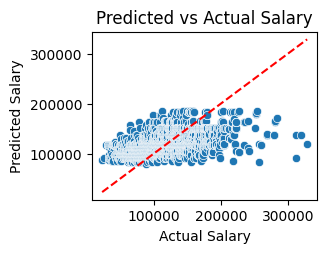

In [42]:
plt.subplot(2, 2, 1)
sns.scatterplot(x=preds_pd["SALARY"], y=preds_pd["prediction"])
min_val = preds_pd["SALARY"].min()
max_val = preds_pd["SALARY"].max()
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Predicted vs Actual Salary")


Text(0.5, 1.0, 'Residuals vs Predicted')

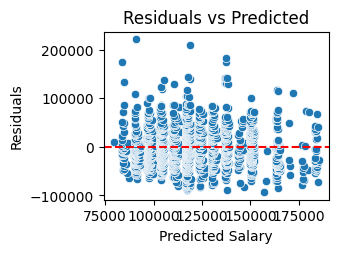

In [43]:
plt.subplot(2, 2, 2)
sns.scatterplot(x=preds_pd["prediction"], y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Salary")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")


Text(0.5, 1.0, 'Histogram of Residuals')

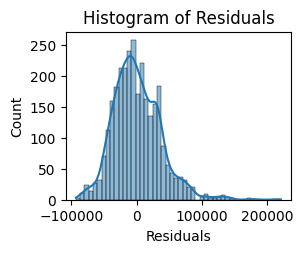

In [44]:
plt.subplot(2, 2, 3)
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals")


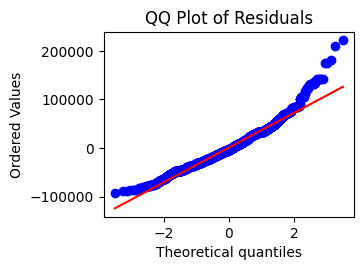

In [45]:
plt.subplot(2, 2, 4)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.tight_layout()


In [46]:
plt.savefig("_output/diagnostic_plots.png")
plt.show()

<Figure size 640x480 with 0 Axes>

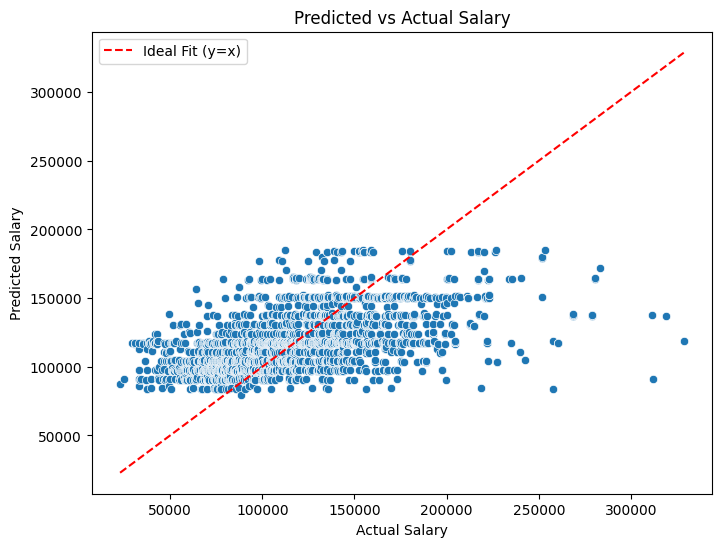

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

predictions = lr_model.transform(test_data)
preds_pd = predictions.select("SALARY", "prediction").toPandas()

min_salary = preds_pd["SALARY"].min()
max_salary = preds_pd["SALARY"].max()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=preds_pd["SALARY"], y=preds_pd["prediction"])
plt.plot([min_salary, max_salary], [min_salary, max_salary], color='red', linestyle='--', label="Ideal Fit (y=x)")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Predicted vs Actual Salary")
plt.legend()
plt.show()

The scatter plot shows how the model’s predicted salaries compare to the actual salaries in the test set. The red dashed line represents the ideal one-to-one fit (y=x), where predictions would match perfectly with reality. Overall, many points fall relatively close to this line, indicating that the model is capturing salary trends. However, there is still noticeable spread, especially at higher salaries, suggesting the model may benefit from further feature engineering or parameter tuning to improve accuracy.

In [48]:
test_result = lr_model.evaluate(test_data)
print("R² (Coefficient of Determination):", test_result.r2)
print("RMSE (Root Mean Squared Error):", test_result.rootMeanSquaredError)
print("MAE (Mean Absolute Error):", test_result.meanAbsoluteError)

R² (Coefficient of Determination): 0.25016179155822793
RMSE (Root Mean Squared Error): 36275.897200279505
MAE (Mean Absolute Error): 28002.521572263366


In [49]:
plt.tight_layout()
plt.savefig("_output/predicted_vs_actual_final.png", dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

In [51]:
import nbformat
try:
    nb = nbformat.read("lab08_hana.ipynb", as_version=4)
    print("Notebook is valid JSON")
except Exception as e:
    print("Error reading notebook:", e)

Error reading notebook: Notebook does not appear to be JSON: ''
